# 인공지능과 가위바위보하기

<br>


## 개요
손글씨 이미지 분류 실습을 통해 학습한 내용을 토대로 가위바위보 게임을 할 수 있는 프로그램을 만들어 보도록 한다. 손글씨 숫자 이미지는 0부터 9까지 총 10개의 클래스로 이루어진 것과는 달리 가위바위보 이미지 분류기는 3가지의 클래스로만 이루어진다. 이미지 분류를 위한 학습에 사용될 데이터셋은 웹캠을 이용하여 직접 생성하여 실제로 어떻게 데이터셋을 만들고 만들어진 데이터를 활용하는지 알아보도록 한다.  
* [이미지 데이터셋 생성 사이트](https://teachablemachine.withgoogle.com/)  

네트워크 설계와 검증이 완료되면 임의의 가위, 바위, 보 사진을 입력받아 그 이미지를 분류하여 컴퓨터가 제시하는 랜덤한 값과 비교하여 승패 여부를 판단하는 프로그램을 완성시킨다.

<br>

## 목차
* 데이터 준비하기
  * 각 클래스의 데이터를 만들어 별도의 디렉터리에 저장
  > dir 명은 rock, scissor, papper로 지정한다.
  * 각 디렉터리에 저장한 이미지 데이터 불러오기
  * 데이터 사이즈 조정
* 딥러닝 네트워크 설계하기
  * Sequential 모델 설계
  > Convolution, pooling, 완전결합 계층을 설계한다.
* 딥러닝 네트워크 학습시키기
  * 매개변수 갱신 방법은 Adam 기법 사용
  * 손실함수는 'sparse_categorical_crossentropy' 사용
* 만들어진 딥러닝 네트워크 검증하기
  * 테스트 데이터셋을 이용하여 만들어진 모델의 성능과 과적합 여부 검증
* 네트워크 정확도 높이기
  * 하이퍼 파라미터 값을 조정하여 더 높은 정확도가 나올 수 있도록 네트워크를 개선
* 가위바위보 게임 로직 구현
  * 이미지 입력받고 분류하기
  * 무작위 값 선정하여 분류된 출력값과 비교하기
  * 승패를 결정하여 승률 계산하기


---
### 데이터 준비하기
학습에 사용할 데이터가 저장되어있는 경로에 접근하여 데이터를 불러오고, 학습에 용이한 형태로 변환하는 과정이다.

In [1]:
import tensorflow as tf
import numpy as np

# 사용할 라이브러리 버전 확인
print(tf.__version__)
print(np.__version__)

2.15.0
1.23.5


In [2]:
# 이미지 크기 변환을 위한 라이브러리 추가
from PIL import Image
import glob
import os

# 이미지 크기 변환 함수 정의
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")

    # 변경 전 파일 개수 확인
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 변환하여 저장
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.LANCZOS)
		new_img.save(img, "JPEG")

    # 변경 후 파일 개수 확인
	print(len(images), " images resized.")


# 가위,바위,보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 크기 변환
paper_dir_path = "/content/rsp/paper"
rock_dir_path = "/content/rsp/rock"
scissor_dir_path = "/content/rsp/scissor"

resize_images(paper_dir_path)
print("보 이미지 resize 완료!")

resize_images(rock_dir_path)
print("바위 이미지 resize 완료!")

resize_images(scissor_dir_path)
print("가위 이미지 resize 완료!")

243  images to be resized.
243  images resized.
보 이미지 resize 완료!
243  images to be resized.
243  images resized.
바위 이미지 resize 완료!
243  images to be resized.
243  images resized.
가위 이미지 resize 완료!


* 이미지가 저장된 경로에 접근하여 224X224 크기의 이미지 파일을 28X28 크기로 변경한다.

In [3]:
import numpy as np

# 데이터를 읽어들이는 함수 정의(이미지 개수 합에 맞춰 데이터 개수는 729개로 지정)
def load_data(img_path, number_of_data=729):
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬 영역 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    # idx 0 영역에 가위 이미지 행렬 복사
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=0
        idx=idx+1

    # idx 1 영역에 가위 이미지 행렬 복사
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1
        idx=idx+1

    # idx 1 영역에 보 이미지 행렬 복사
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2
        idx=idx+1

    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "/content/rsp"
# load_data 함수 호출 후 반환값을 x_train, y_train 변수에 바인딩
(x_train, y_train)=load_data(image_dir_path)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 729 입니다.
x_train shape: (729, 28, 28, 3)
y_train shape: (729,)


* 학습 데이터의 개수는 총 729개이며, 이미지의 크기는 28X28, 3개의 채널(RGB)로 구성되어있다.

라벨:  0


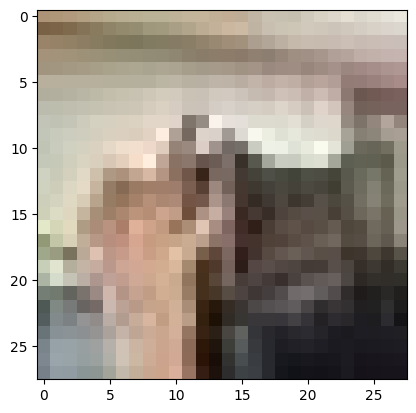

In [4]:
import matplotlib.pyplot as plt

# 학습 데이터와 정답 라벨 샘플 확인
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

* 28X28의 형태로 축소가 되어 정확히 구분은 안가지만, 자세히 보면 가위의 형태를 띄고 있고 그에 맞는 라벨 값이 출력된 것을 알 수 있다.

In [5]:
# 정규화를 위한 최대/최솟값 확인
print('최소값:',np.min(x_train), ' 최대값:',np.max(x_train))

최소값: 0  최대값: 255


In [6]:
# 데이터를 0과 1사이 값으로 정규화
x_train_norm = x_train / 255.0
print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm))

최소값: 0.0  최대값: 1.0


* 전체 학습 데이터를 최댓값인 255로 나눠 모든 데이터가 0과 1사이의 값을 가질 수 있도록 하여 정규화를 진행한다.

---
### 딥러닝 네트워크 설계하기
어떤 학습 모델을 사용할 것인지, 신경망은 어떻게 구성할 것인지 고려하며 설계를 진행한다. 해당 단계에서는 keras 모듈의 Sequential 모델을 사용한다.

In [7]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

#keras의 Sequential 모델로 네트워크 설계
model=keras.models.Sequential()
# 1번 레이어 - 합성곱 계층: 필터 개수 32, 필터 크기 3X3, 활성화 함수 ReLU, 데이터 크기 28X28X3
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
# 2번 레이어 - 풀링 계층: 맥스 풀링, 풀링 크기 2X2, stride 2X2
model.add(keras.layers.MaxPool2D(2,2))
# 3번 레이어 - 합성곱 계층: 필터 개수 32, 필터 크기 3X3, 활성화 함수 ReLU
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
# 4번 레이어 - 풀링 계층: 맥스 풀링, 풀링 크기 2X2, stride 2X2
model.add(keras.layers.MaxPooling2D((2,2)))
# 5번 레이어 - 데이터 전개 계층: 입력 데이터 전개
model.add(keras.layers.Flatten())
# 6번 레이어 - 완전연결 계층: 뉴런 개수 32, 필터 크기 3X3, 활성화 함수 ReLU
model.add(keras.layers.Dense(32, activation='relu'))
# 7번 레이어 - 출력 계층: 출력 노드 개수 3, 출력함수 Softmax
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 32)                2

* 2개의 합성곱 계층과 2개의 풀링 계층을 거쳐 3개의 노드를 출력하는 모델을 설계한다.

---
### 딥러닝 네트워크 학습시키기
학습을 진행할 때 가중치 업데이트 방법, 손실함수, 평가지표 등 고려해야할 사항과 그 종류를 파악해야 한다. 학습 과정의 정확도와 학습 완료 후의 정확도를 비교하며 학습이 진행하는 과정에서의 정확도의 변화를 주시한다.


In [8]:
# 가중치 업데이트 방법 adam, 손실함수 sparse_categorical_crossentropy, 평가지표 정확도
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10
23/23 [==============================] - 3s 14ms/step - loss: 1.0716 - accuracy: 0.5007
Epoch 2/10
23/23 [==============================] - 0s 4ms/step - loss: 0.9421 - accuracy: 0.5720
Epoch 3/10
23/23 [==============================] - 0s 4ms/step - loss: 0.6580 - accuracy: 0.7942
Epoch 4/10
23/23 [==============================] - 0s 3ms/step - loss: 0.4292 - accuracy: 0.8368
Epoch 5/10
23/23 [==============================] - 0s 4ms/step - loss: 0.3149 - accuracy: 0.8820
Epoch 6/10
23/23 [==============================] - 0s 4ms/step - loss: 0.2435 - accuracy: 0.9026
Epoch 7/10
23/23 [==============================] - 0s 3ms/step - loss: 0.1822 - accuracy: 0.9314
Epoch 8/10
23/23 [==============================] - 0s 3ms/step - loss: 0.1380 - accuracy: 0.9534
Epoch 9/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0997 - accuracy: 0.9726
Epoch 10/10
23/23 [==============================] - 0s 4ms/step - loss: 0.0735 - accuracy: 0.9739


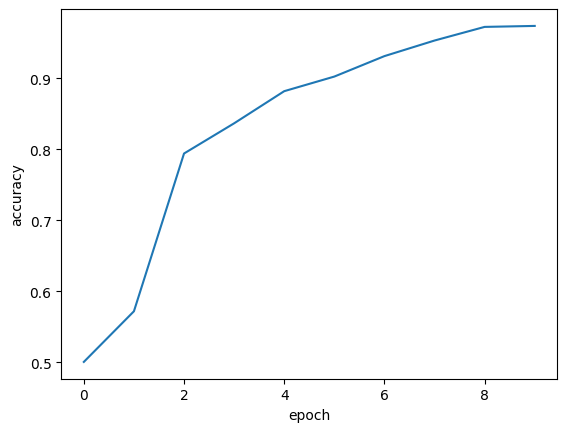

In [10]:
# 에폭 증가에 따른 정확도 변화를 그래프로 그리기
history = model.history

plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

* 에폭을 거듭할수록 정확도가 점점 높아지는 것을 확인할 수 있다.

---
### 만들어진 딥러닝 네트워크 검증하기
지정된 데이터만으로 학습을 진행하다보면 오버피팅의 염려가 있다. 새로운 검증 데이터를 통해 오버피팅 여부를 확인하여 모델의 성능을 파악한다.

In [11]:
# 테스트 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 크기 변환
paper_dir_path = "/content/rsp/paper_test"
rock_dir_path = "/content/rsp/rock_test"
scissor_dir_path = "/content/rsp/scissor_test"

resize_images(paper_dir_path)
print("보 test 이미지 resize 완료!")

resize_images(rock_dir_path)
print("바위 test 이미지 resize 완료!")

resize_images(scissor_dir_path)
print("가위 test 이미지 resize 완료!")

100  images to be resized.
100  images resized.
보 test 이미지 resize 완료!
100  images to be resized.
100  images resized.
바위 test 이미지 resize 완료!
100  images to be resized.
100  images resized.
가위 test 이미지 resize 완료!


In [12]:
import numpy as np

# 테스트 데이터를 읽어들이는 함수 정의(이미지 개수 합에 맞춰 데이터 개수는 729개로 지정)
def load_test(img_path, number_of_data=300):
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬 영역 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    # idx 0 영역에 가위 이미지 행렬 복사
    for file in glob.iglob(img_path+'/scissor_test/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=0
        idx=idx+1

    # idx 1 영역에 가위 이미지 행렬 복사
    for file in glob.iglob(img_path+'/rock_test/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1
        idx=idx+1

    # idx 1 영역에 보 이미지 행렬 복사
    for file in glob.iglob(img_path+'/paper_test/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2
        idx=idx+1

    print("검증데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = "/content/rsp"
# load_test 함수 호출 후 반환값을 x_test, y_test 변수에 바인딩
(x_test, y_test)=load_test(image_dir_path)

# 검증 데이터 정규화
x_test_norm = x_test/255.0

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

검증데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


* 300개의 데이터 크기를 244X244에서 28X28로 변환한다.
* 300개의 데이터를 검증 데이터와 정답 라벨로 분리 후 0에서 1사이의 값이 되도록 정규화를 진행한다.

In [13]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 3.3720 - accuracy: 0.3467 - 324ms/epoch - 32ms/step
test_loss: 3.371952772140503
test_accuracy: 0.3466666638851166


* 학습 결과 정확도는 97%였지만, 검증 결과 정확도는 34.6%로 모델이 학습데이터에 오버피팅 됐다는 것을 알 수 있다.

---
### 네트워크 정확도 높이기
위의 결과에서 알 수 있 듯이, 학습 결과 정확도와 검증 결과 정확도가 약 62% 정도 차이가 난다. 이 차이가 아니더라도 검증 결과 정확도가 34.6%라는 것은 터무니 없는 성능을 보이는 것이므로 모델을 개선할 필요가 있다.

In [21]:
# 학습 데이터 추가
paper_dir_path = "/content/rsp/paper"
rock_dir_path = "/content/rsp/rock"
scissor_dir_path = "/content/rsp/scissor"

resize_images(paper_dir_path)
print("보 이미지 resize 완료!")

resize_images(rock_dir_path)
print("바위 이미지 resize 완료!")

resize_images(scissor_dir_path)
print("가위 이미지 resize 완료!")


image_dir_path = "/content/rsp"
# load_data 함수 호출 후 반환값을 x_train, y_train 변수에 바인딩
(x_train, y_train)=load_data(image_dir_path, 3146)

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

976  images to be resized.
976  images resized.
보 이미지 resize 완료!
1177  images to be resized.
1177  images resized.
바위 이미지 resize 완료!
993  images to be resized.
993  images resized.
가위 이미지 resize 완료!
학습데이터(x_train)의 이미지 개수는 3146 입니다.
x_train shape: (3146, 28, 28, 3)
y_train shape: (3146,)


* 학습 데이터의 개수를 기존 729개에서 3146개로 증량한 후, 기존과 동일하게 크기를 28X28로 변환한다.

In [22]:
# 데이터를 0과 1사이 값으로 정규화
x_train_norm = x_train / 255.0
print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm))

최소값: 0.0  최대값: 1.0


* 데이터가 학습에 용이해지도록 정규화를 진행한다.

In [56]:
from keras import regularizers

#keras의 Sequential 모델 네트워크 재설계
model=keras.models.Sequential()
# 1번 레이어 - 합성곱 계층: 필터 개수 16, 필터 크기 3X3, 활성화 함수 ReLU, 데이터 크기 28X28X3
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
# 2번 레이어 - 풀링 계층: 맥스 풀링, 풀링 크기 2X2, stride 2X2
model.add(keras.layers.MaxPool2D(2,2))
# 3번 레이어 - 합성곱 계층: 필터 개수 16, 필터 크기 3X3, 활성화 함수 ReLU
model.add(keras.layers.Conv2D(16, (3,3), activation='relu'))
# 4번 레이어 - 풀링 계층: 맥스 풀링, 풀링 크기 2X2, stride 2X2
model.add(keras.layers.MaxPooling2D((2,2)))
# 5번 레이어 - 데이터 전개 계층: 입력 데이터 전개
model.add(keras.layers.Flatten())
# 뉴런의 70%만 사용하도록 dropout 추가
model.add(keras.layers.Dropout(0.3))
# 6번 레이어 - 완전연결 계층: 뉴런 개수 16, 필터 크기 3X3, 활성화 함수 ReLU, L2 규제 적용
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
# 7번 레이어 - 출력 계층: 출력 노드 개수 3, 출력함수 Softmax
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 13, 13, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 11, 11, 16)        2320      
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 5, 5, 16)          0         
 ng2D)                                                           
                                                                 
 flatten_11 (Flatten)        (None, 400)               0         
                                                                 
 dropout_10 (Dropout)        (None, 400)             

* 오버피팅 문제를 해결하기 위해 일부 하이퍼 파라미터 값을 변경한다.
    * 합성곱 필터 개수: 32개 -> 16개
    * dropout을 적용시켜 전체 뉴런의 70%만 활성화
    * 완전연결 계층에 L2 규제 적용

Epoch 1/10
99/99 [==============================] - 2s 4ms/step - loss: 2.2046 - accuracy: 0.3744
Epoch 2/10
99/99 [==============================] - 0s 4ms/step - loss: 1.1315 - accuracy: 0.4421
Epoch 3/10
99/99 [==============================] - 1s 7ms/step - loss: 0.9565 - accuracy: 0.5969
Epoch 4/10
99/99 [==============================] - 0s 4ms/step - loss: 0.7419 - accuracy: 0.7441
Epoch 5/10
99/99 [==============================] - 0s 4ms/step - loss: 0.6161 - accuracy: 0.8093
Epoch 6/10
99/99 [==============================] - 0s 4ms/step - loss: 0.5393 - accuracy: 0.8490
Epoch 7/10
99/99 [==============================] - 0s 4ms/step - loss: 0.4977 - accuracy: 0.8706
Epoch 8/10
99/99 [==============================] - 0s 4ms/step - loss: 0.4513 - accuracy: 0.8773
Epoch 9/10
99/99 [==============================] - 0s 4ms/step - loss: 0.4337 - accuracy: 0.8827
Epoch 10/10
99/99 [==============================] - 0s 4ms/step - loss: 0.3946 - accuracy: 0.9037


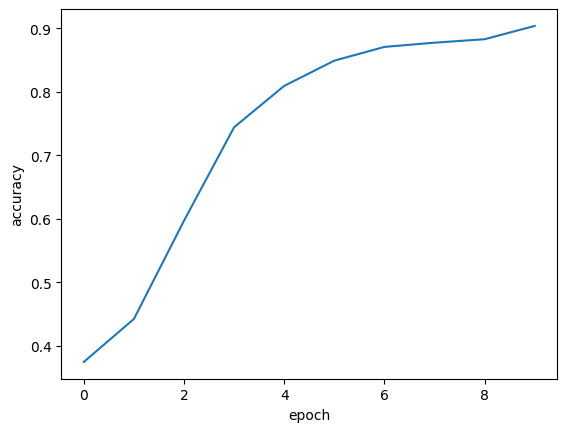

In [57]:
from keras.optimizers import Adam
# Adam 가중치 0.01 적용
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)

history = model.history

plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [58]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 1.3312 - accuracy: 0.6067 - 248ms/epoch - 25ms/step
test_loss: 1.3311718702316284
test_accuracy: 0.6066666841506958


* 일단 60% 넘었으니까 현재 설정값을 유지하고 아래에 다시 설계해보도록 한다.

Epoch 1/50
99/99 [==============================] - 3s 8ms/step - loss: 1.2305 - accuracy: 0.4243 - val_loss: 1.1512 - val_accuracy: 0.5867
Epoch 2/50
99/99 [==============================] - 1s 6ms/step - loss: 0.9224 - accuracy: 0.6405 - val_loss: 0.9965 - val_accuracy: 0.5300
Epoch 3/50
99/99 [==============================] - 0s 5ms/step - loss: 0.6607 - accuracy: 0.7670 - val_loss: 0.9187 - val_accuracy: 0.5967
Epoch 4/50
99/99 [==============================] - 0s 4ms/step - loss: 0.5244 - accuracy: 0.8290 - val_loss: 0.8932 - val_accuracy: 0.5967
Epoch 5/50
99/99 [==============================] - 0s 4ms/step - loss: 0.4544 - accuracy: 0.8671 - val_loss: 1.0120 - val_accuracy: 0.5800
Epoch 6/50
99/99 [==============================] - 0s 4ms/step - loss: 0.3706 - accuracy: 0.9005 - val_loss: 1.4099 - val_accuracy: 0.6033
Epoch 7/50
99/99 [==============================] - 0s 5ms/step - loss: 0.3532 - accuracy: 0.9085 - val_loss: 1.5542 - val_accuracy: 0.5900
Epoch 8/50
99/99 [==

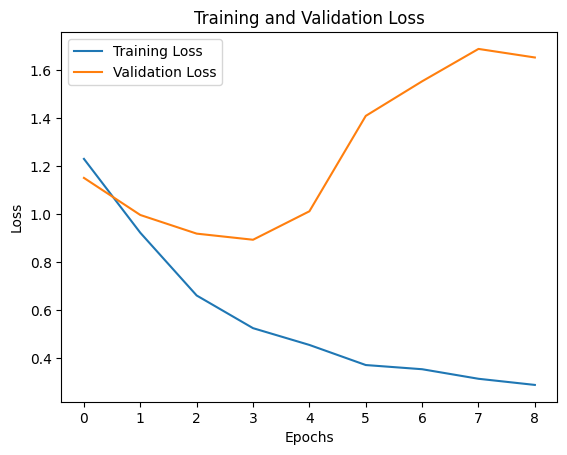

In [77]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dense(3, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 데이터를 회전, 이동, 변형, 축소, 확대, 반전, 패딩 등의 방법으로 변환
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# datagen.fit(x_train_norm)
# model.fit(datagen.flow(x_train_norm, y_train, batch_size=50), epochs=40)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(x_train_norm, y_train, epochs=50, validation_data=(x_test_norm, y_test), callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/40
99/99 [==============================] - 2s 5ms/step - loss: 1.1364 - accuracy: 0.3684
Epoch 2/40
99/99 [==============================] - 1s 5ms/step - loss: 1.0898 - accuracy: 0.3967
Epoch 3/40
99/99 [==============================] - 1s 5ms/step - loss: 1.0103 - accuracy: 0.4609
Epoch 4/40
99/99 [==============================] - 0s 5ms/step - loss: 0.9056 - accuracy: 0.5823
Epoch 5/40
99/99 [==============================] - 1s 5ms/step - loss: 0.8051 - accuracy: 0.6767
Epoch 6/40
99/99 [==============================] - 1s 5ms/step - loss: 0.7458 - accuracy: 0.7012
Epoch 7/40
99/99 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 0.7250
Epoch 8/40
99/99 [==============================] - 0s 4ms/step - loss: 0.6757 - accuracy: 0.7374
Epoch 9/40
99/99 [==============================] - 0s 4ms/step - loss: 0.6185 - accuracy: 0.7708
Epoch 10/40
99/99 [==============================] - 0s 4ms/step - loss: 0.5708 - accuracy: 0.7861
Epoch 11/40
99/99 [

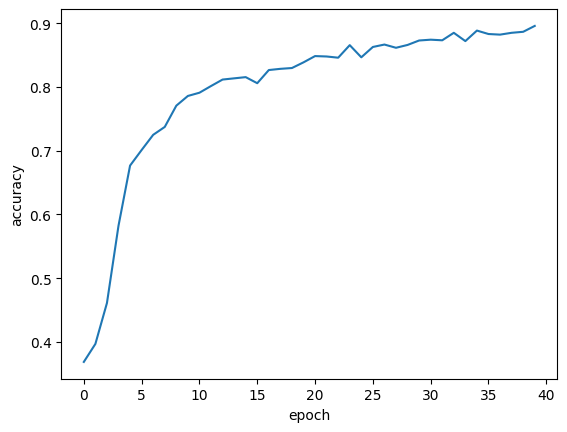

In [82]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dense(3, activation='softmax'))

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=40)

history = model.history

test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

Epoch 1/40
99/99 [==============================] - 3s 7ms/step - loss: 1.1262 - accuracy: 0.3716
Epoch 2/40
99/99 [==============================] - 1s 6ms/step - loss: 1.0939 - accuracy: 0.3741
Epoch 3/40
99/99 [==============================] - 0s 4ms/step - loss: 1.0820 - accuracy: 0.3976
Epoch 4/40
99/99 [==============================] - 0s 4ms/step - loss: 1.0638 - accuracy: 0.4278
Epoch 5/40
99/99 [==============================] - 0s 4ms/step - loss: 0.9910 - accuracy: 0.5184
Epoch 6/40
99/99 [==============================] - 0s 4ms/step - loss: 0.9394 - accuracy: 0.5769
Epoch 7/40
99/99 [==============================] - 0s 4ms/step - loss: 0.8428 - accuracy: 0.6313
Epoch 8/40
99/99 [==============================] - 0s 3ms/step - loss: 0.7598 - accuracy: 0.6863
Epoch 9/40
99/99 [==============================] - 0s 3ms/step - loss: 0.7175 - accuracy: 0.7158
Epoch 10/40
99/99 [==============================] - 0s 4ms/step - loss: 0.6734 - accuracy: 0.7352
Epoch 11/40
99/99 [

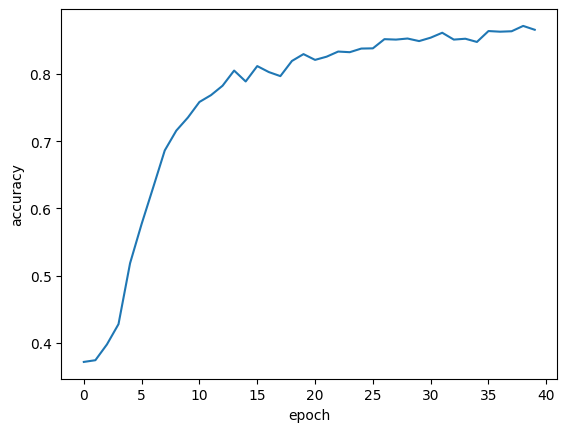

In [92]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(3,3))
model.add(keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((3,3)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(keras.layers.Dense(3, activation='softmax'))

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=40)

history = model.history

test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**최종 결과**  
* 하기 요약된 하이퍼 파라미터 조정을 통해 처음 34.6%의 정확도에서 74%의 정확도로 약 40% 향상된 성능을 확인할 수 있다.

---
### 가위바위보 게임 로직 구현하기

---
## 요약
가위, 바위, 보 이미지 데이터를 학습 시킨 후, 이미지 분류기를 만들어봤다. 처음 검증 정확도가 36%가 나와 정확도를 증가시키려는 노력을 해봤지만, 74%까지밖에 못 올렸다. 시도해본 방법은 다음과 같다.
* 데이터 증가: 여러 사람의 가위, 바위, 보 이미지를 학습 데이터에 추가
* 하이퍼 파라미터 조정:
    * 필터 개수 32개에서 16개로 조정
    * 풀링 크기 2X2에서 3X3으로 조정
    * L2 규제 0.01 설정
    * 완전결합층 노드 개수 32개에서 16개로 축소
    * dropout으로 학습 시 신호를 전달하는 노드를 50%로 축소
    * 학습률 0.01로 설정
> 그 외에 과적합을 방지하여 학습을 조기종료하는 EarlyStopping 모듈과 데이터를 회전, 이동, 변형, 축소, 확대, 반전, 패딩 등의 방법으로 변환하여 증량시키는 ImageDataGenerator 모듈을 사용해봤지만, 해당 모듈로는 정확도 증가가 이뤄지지 않았다.
* 에폭 조정: 하이퍼 파라미터 값 조정으로 인한 정확도 손실을 방지하기 위해 학습 횟수를 10에서 40으로 증가  
여유가 있을 때, 모델 선정부터 설계를 다시 한 번 검토해봐야 할 것 같다.


## 회고

### KEEP
* 정확도를 올리려는 과정에서 조정하는 항목에 대해 이해했다.
* 데이터를 생성하고 학습까지 하나의 플로우를 이해하며 학습했다.  

### PROBLEM
* 하이퍼 파라미터 등을 조정할 때, 각 항목이 다른 항목에 미치는 영향을 이해하지 못했다.  

### TRY
* 정확도를 올리려는 시도를 진행할 때, 항목 별 영향에 대한 이해와 테스트 케이스를 정리한 후 작업을 해야겠다.